## Basic Text Classification with Naive Bayes
***

The dataset is a subset of movie reviews from rotten tomatoes database. 

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv(r'''C:\Users\mia\Documents\Python Scripts\naive_bayes/critics.csv''')

# drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


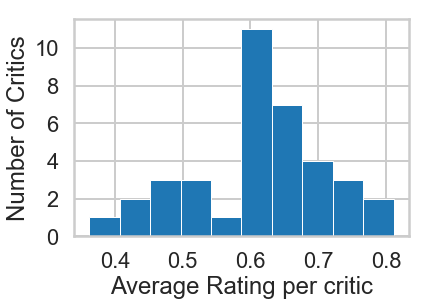

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

# plot a histogram of the average freshness of each critic who
# posted more than 100 reviews
n,bins, bars = plt.hist(means[counts > 100],edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

It looks like the most common average rating for those critics who have more 100 reviews is about 0.6. The worst average rating is around 0.4 and the highest is not as high as 0.9. More critics have an average rating greater than or equal to 0.6. The histogram is almost a belly-shape, except for the only one critic who has an average rating around 0.55. 

The distribution looks like a normal distribution, which is really friendly to statisticians. 

***

Maybe the exception is bad samples. So next, I will take a look at that particular critic's reviews and see if those data is somehow fishy.

In [5]:
bins = n[1]
bins

2.0

In [6]:
counts[(means > 0.54) & (means <= 0.5867) & (counts > 100)]

critic
Jeff Millar    164
Name: critic, dtype: int64

In [7]:
df.loc[df.critic == 'Jeff Millar'].select_dtypes(exclude='int64').describe().T

,count,unique,top,freq
critic,164,1,Jeff Millar,164
fresh,164,2,True,91
publication,164,1,Houston Chronicle,164
quote,164,164,Berkowitz is a rather annoying person.,1
review_date,164,7,2000-01-01,124
title,164,164,Le notti di Cabiria,1


In [8]:
df.loc[df.critic == 'Jeff Millar'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164 entries, 383 to 27506
Data columns (total 8 columns):
critic         164 non-null object
fresh          164 non-null bool
imdb           164 non-null int64
publication    164 non-null object
quote          164 non-null object
review_date    164 non-null object
rtid           164 non-null int64
title          164 non-null object
dtypes: bool(1), int64(2), object(5)
memory usage: 10.4+ KB


Nothing seems weird. 164 unique reviews on 164 unique movies, so those reviews data from this critic is good. It might just be due to chance that only one critic's freshness falls into that particular range. I could always change the number of bins and see if that'll make the histogram more like a normal distribution.

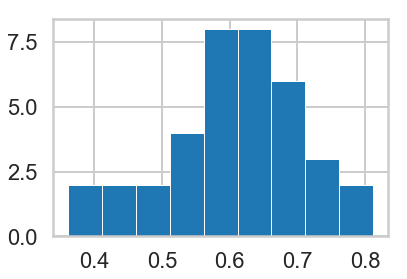

In [9]:
n, bins, bars = plt.hist(means[counts > 100],bins=9, edgecolor='w', lw=1)

There we go. 

## Convert Data to Numeric

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

def make_xy(critics, vectorizer=None):
    
    if vectorizer is None:
        vectorizer = CountVectorizer()
        
    X = vectorizer.fit_transform(critics.quote)
    
    X = X.tocsc()  
    
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y

X, y = make_xy(critics)

## Train A Simple Naive Bayes Classifier

In [11]:
# Use the MultinomialNB classifier from sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# spli data into training set and test tset
X_train, X_test, y_train, y_test = train_test_split(X,y)


mnb = MultinomialNB()
mnb.fit(X_train,y_train)

print('The accuracy score for the training set is {0:.3f}'.format(mnb.score(X_train, y_train)))
print('The accuracy score for the test set is {0:.3f}'.format(mnb.score(X_test, y_test)))



The accuracy score for the training set is 0.922
The accuracy score for the test set is 0.779


The accuracy on the training data is much better than on the test set. This is an overfit classifier.

### Pick Hyperparameters for  Word Convertor
***
I am going to construct the cumulative distribution of document frequencies. The  $x$-axis is a document count  $x_i$  and the  $y$-axis is the percentage of words that appear less than  $x_i$   times. Then, look for the point at which the curve begins climbing steeply, where may be a good value for `min_df` for the word convertor.

Text(0,0.5,'Percentage')

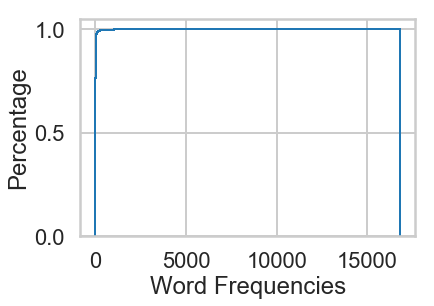

In [12]:
X = X.toarray()
counts = X.sum(axis=0)
plt.hist(np.sort(counts), bins=np.unique(counts), histtype='step', cumulative=True,density=True)
plt.xlabel('Word Frequencies')
plt.ylabel('Percentage')

The are a few outliers in the word frequencies. Those words have very high frequencies that are more then 1000. Some even appears for more than 15,000 times. As it is the stop word that I am trying to find, it is better to zoom in this cumulative distribution plot. After try different ranges for x axis, the best one to find where the curve begins climbing steeply is from 0 to 250.

Text(0,0.5,'Percentage')

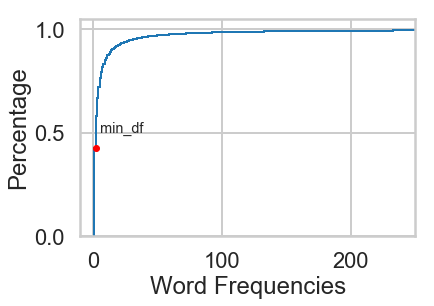

In [13]:
n, bins,patches = plt.hist(np.sort(counts), bins=np.unique(counts), histtype='step', cumulative=True,density=True)
plt.xlim(-10, 250)
plt.plot(2,np.sum(counts < 2)/len(counts),marker='.', color='r', markersize=12)
plt.annotate('min_df',(3,np.sum(counts < 3)/len(counts)),xytext=(5, 0.5),fontsize='x-large')
plt.xlabel('Word Frequencies')
plt.ylabel('Percentage')

It looks like the curve is climbing steeply when the frequency is less than 2, so my min_df is going to be 1.

### Pick Hyperparameters for  Naive Bayes Classifier -- $\\alpha$
***

The function `cv_score` performs the K-fold cross-validation algorithm but it needs passing a function that measures the performance of the algorithm on each fold. The log-likelihood will be used as the score here in `scorefunc`. The higher the log-likelihood, the better. 

In [14]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [15]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [16]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

C:\Users\mia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 34 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    
    clf = MultinomialNB(alpha)
    cvscore = cv_score(clf, Xtrainthis, ytrainthis,log_likelihood)
    
    if cvscore > maxscore:
        maxscore = cvscore
        best_alpha = alpha

print('The best alpha is {0:0}.'.format(best_alpha))     

The best alpha is 5.


## Build the Model with the Best $\\alpha$

In [18]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.759477
Accuracy on test data:     0.695648


The accuracy on test data is about 6% less than the training data. This is definitely not a overfitted classifier but it is likely to be imporved.

In [19]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2074 2215]
 [1100 5503]]


## The Strongly Predictive Features

In [20]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
              modern 0.86
           wonderful 0.84
           excellent 0.84
         intelligent 0.83
            powerful 0.83
               smart 0.83
              highly 0.83
            greatest 0.83
               since 0.82
                rich 0.82
Bad words	     P(fresh | word)
               flick 0.30
               fails 0.30
                 isn 0.30
               video 0.29
               bland 0.29
             problem 0.29
                flat 0.28
             neither 0.28
                dull 0.27
       unfortunately 0.21


### Prediction Errors

We can see mis-predictions as well.

In [21]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
Nary a tear-jerking trick is missed (our family loses one son to the Titanic, the other to World War I), and the strangulation is compounded by the staginess since the film.

It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.

It is sometimes funny in a puzzling kind of way, it is generally overwrought in an irritating kind of way, and once in a while it is inappropriately touching.

Walken is one of the few undeniably charismatic male villains of recent years; he can generate a snakelike charm that makes his worst characters the most memorable, and here he operates on pure style.

Though based on an original and respected novel, Hyams' horror thriller comes across as a pastiche of the genre's conventions as evident in major pictures of the past two deca

# Predict New Reviews 

In [22]:
mytext = ['This movie is not remarkable, touching, or superb in any way']

myx = vectorizer.transform(mytext)


clf.predict_proba(myx)[:, 0]

array([0.0904191])

This is what I'd expect that this review is not a positive review.

In [23]:
mytext2 = ['If anything, this material is too rich for a single documentary']

myx = vectorizer.transform(mytext2)


clf.predict_proba(myx)[:, 0]

array([0.70273069])

The model gives a positive result, but in fact it is more like a negative review. I would say that the sentiment of this movie review is a bit harder for my 'simple' model to detect. 